## Loading Data

### Read Csv

In [4]:
import pandas as pd

df = pd.read_csv('../Datasets/indonesian-abusive-and-hate-speech-twitter-text/data.csv', encoding='latin-1')

### Grouping The Data

In [5]:
positive_both = df[(df['HS'] == 1) & (df['Abusive'] == 1)].drop(columns=['Abusive','HS_Individual','HS_Group','HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other','HS_Weak','HS_Moderate','HS_Strong'])
positive_hs = df[(df['HS'] == 1) & (df['Abusive'] == 0)].drop(columns=['Abusive','HS_Individual','HS_Group','HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other','HS_Weak','HS_Moderate','HS_Strong'])
positive_a = df[(df['HS'] == 0) & (df['Abusive'] == 1)].drop(columns=['HS','HS_Individual','HS_Group','HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other','HS_Weak','HS_Moderate','HS_Strong'])
negative = df[(df['HS'] == 0) & (df['Abusive'] == 0)].drop(columns=['Abusive','HS_Individual','HS_Group','HS_Religion','HS_Race','HS_Physical','HS_Gender','HS_Other','HS_Weak','HS_Moderate','HS_Strong'])

In [6]:
positive_both = positive_both.rename(columns={'Tweet':'text','HS':'label'})
positive_both.count()

text     3295
label    3295
dtype: int64

In [7]:
positive_hs = positive_hs.rename(columns={'Tweet':'text','HS':'label'})
positive_hs.count()

text     2266
label    2266
dtype: int64

In [8]:
positive_a = positive_a.rename(columns={'Tweet':'text','Abusive':'label'})
positive_a.count()

text     1748
label    1748
dtype: int64

In [9]:
negative = negative.rename(columns={'Tweet':'text','HS':'label'})
negative.count()

text     5860
label    5860
dtype: int64

In [10]:
df = pd.concat([positive_hs, positive_a, positive_both, negative], ignore_index=True)

In [11]:
df.head()

,text,label
0,Aktor huruhara 98 Prabowo S ingin lengserkan p...,1
1,RT USER USER USER PKI hanya muncul jika jelang...,1
2,USER USER USER USER USER USER USER USER USER I...,1
3,pinokio umur 3 taonan tuh. #2019GantiPresiden,1
4,RT USER benci sekali dgn Umat Islam,1


### Checking the data balance

In [12]:
df[df['label'] == 0].count()

text     5860
label    5860
dtype: int64

In [13]:
df[df['label'] == 1].count()

text     7309
label    7309
dtype: int64

<Axes: xlabel='label', ylabel='count'>

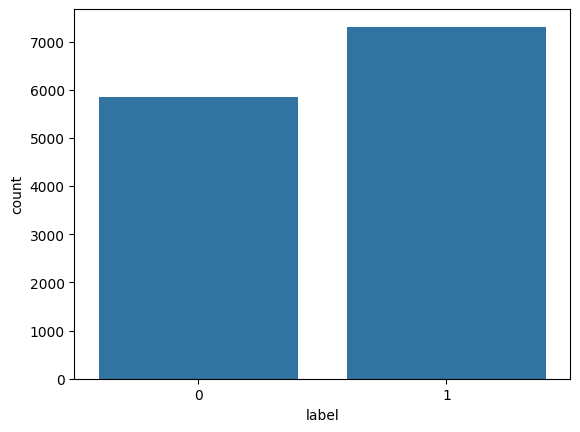

In [14]:
import seaborn as sns

sns.countplot(x='label', data=df)

### Downsample to balance the data

In [15]:
from sklearn.utils import resample
df0 = df[(df['label']==0)]
df1 = df[(df['label']==1)]

n = 5860

df0 = resample(df0,
              replace=True,
              n_samples= n,
              random_state=42)

df1 = resample(df1,
              replace=True,
              n_samples= n,
              random_state=42)

df = pd.concat([df0,df1], ignore_index=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11720 non-null  object
 1   label   11720 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 183.3+ KB


### Checking the data balance after downsample

<Axes: xlabel='label', ylabel='count'>

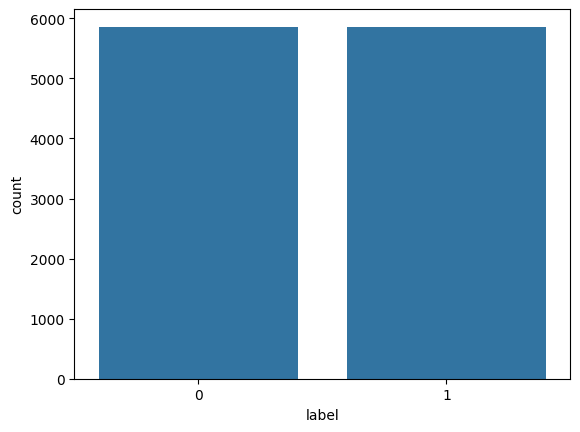

In [17]:
import seaborn as sns

sns.countplot(x='label', data=df)

## Preprocessing Data

### Create functions to process text data

In [18]:
import re
import unicodedata

import numpy as np

def lowercase(text):
  return text.lower()

def remove_stair(text):
  return re.sub('#',' ',text)

def remove_enter(text):
  return re.sub('\n',' ',text)

def remove_retweet(text):
  return re.sub('rt',' ',text)

def remove_user(text):
  return re.sub('user',' ',text)

def remove_url(text):
  return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)

def remove_unicode(text):
  text = re.sub(r'\bx[a-fA-F0-9]{2}\b', ' ', text)
  text = re.sub(r'\bx([a-fA-F0-9]{2})', ' ', text)
  return text

def remove_nonaplhanumeric(text):
  return re.sub('[^a-zA-Z]+', ' ', text)

alay = pd.read_csv('../Datasets/indonesian-abusive-and-hate-speech-twitter-text/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = dict(zip(alay[0], alay[1]))
def normalize_alay(text):
  return ' '.join([alay_dict[word] if word in alay_dict else word for word in text.split(' ')])

stopwords = pd.read_csv('../Datasets/indonesian-stoplist/stopwordbahasa.csv', header=None)
stopwords_indonesia = np.concatenate((stopwords[0].values, ['nih', 'sih', 'gue', 'lu', 'uniform', 'resource', 'locator', 'nya', 'ya', 'jokowi', 'prabowo', 'ahok', 'bambang', 'yudhoyono']))
def remove_stopword(text):
  text = ' '.join(['' if word in stopwords_indonesia else word for word in text.split(' ')])
  text = remove_extra_spaces(text)
  text = text.strip()
  return text

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer_indonesia = factory.create_stemmer()
def stemming(text):
  return stemmer_indonesia.stem(text)

def remove_extra_spaces(text):
  text = re.sub(r'\s+', ' ', text)
  text = text.strip()
  return text

<>:22: SyntaxWarning: invalid escape sequence '\.'
<>:22: SyntaxWarning: invalid escape sequence '\.'
C:\Users\mdodd\AppData\Local\Temp\ipykernel_1928\1889865700.py:22: SyntaxWarning: invalid escape sequence '\.'
  return re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)


In [19]:
def clean_text(text):
  text = lowercase(text)
  text = remove_stair(text)
  text = remove_enter(text)
  text = remove_retweet(text)
  text = remove_user(text)
  text = remove_url(text)
  text = remove_unicode(text)
  text = remove_nonaplhanumeric(text)
  text = remove_extra_spaces(text)
  text = normalize_alay(text)
  text = remove_stopword(text)
  text = remove_extra_spaces(text)
  text = stemming(text)
  return text

### Applying text cleaner function

In [20]:
df['text'] = df['text'].apply(clean_text)
df.head(100)

,text,label
0,teliti orang kristen cina hehe,0
1,agama pakai pakai ketat lekuk tubuh sama orang...,0
2,tomohon pusat ajar agama kristen katolik khusu...,0
3,mandang orang agama kayak peduli agama orang t...,0
4,guntur romli,0
...,...,...
95,festival pesona tambora angkat eksotisme alam ...,0
96,deklarasi anti hoaks pilih kepala daerah damai...,0
97,be anya tuju hati logika hati tenang be anya l...,0
98,buah ketapang makan onta abang cinta,0


### Deleting data that has string empty text

In [21]:
# len(df[df['text'].str.split().str.len() < 1])
# len(df[df['text'] == ''].values)
df = df[df['text'] != '']

### Creating wordcloud

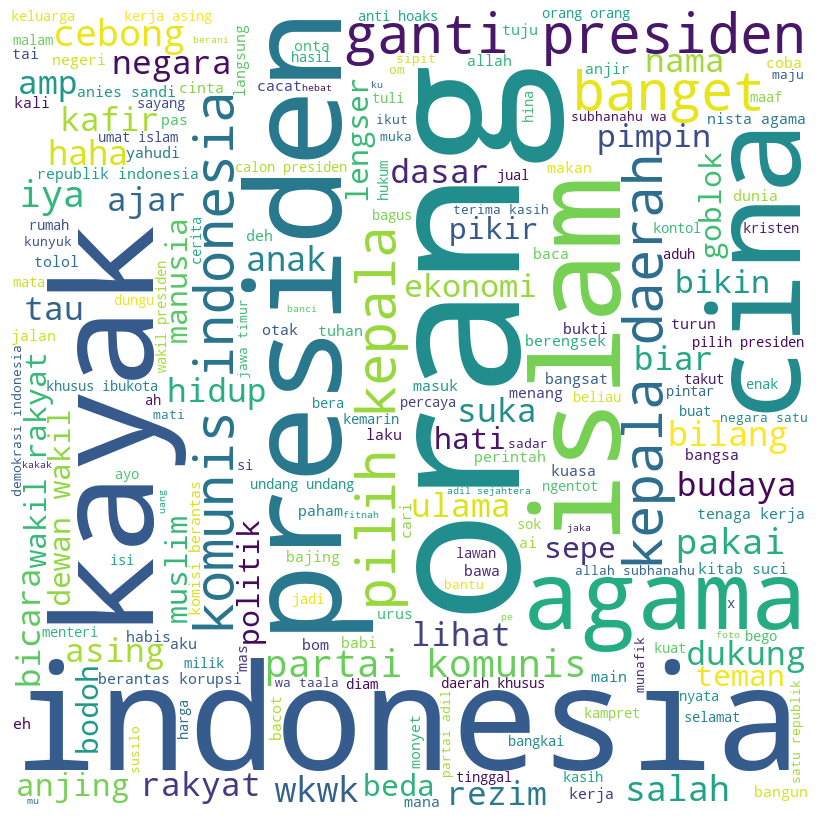

In [22]:
wc = ''

for words in df['text'].values:
  wc += ' '+words

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(wc)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Creating word index

In [23]:
import re

def generate_word_index(texts):
    word_index = {}
    index = 1  # Start indexing from 1, reserve index 0 for unknown words
    for text in texts:
        tokens = re.findall(r'\w+', text.lower())
        for token in tokens:
            if token not in word_index:
                word_index[token] = index
                index += 1
    return word_index

word_index = generate_word_index(df['text'].values)
len(word_index)

9905

### Calculating longest text by words

In [24]:
longest_text = 0
for text in df['text'].values:
  if len(text.split(' ')) > longest_text:
    longest_text = len(text.split(' '))

longest_text

45

### Tokenizing words based on created word index

In [25]:
df_ready_to_train = df.copy()
df_ready_to_train['text'] = df_ready_to_train['text'].apply(lambda text: [word_index.get(word, 0) for word in re.split(r'\W+', text.lower())])

In [26]:
import tensorflow as tf

df_ready_to_train['text'] = list(tf.keras.preprocessing.sequence.pad_sequences(df_ready_to_train['text'], maxlen=longest_text, padding='post'))

## Saving Data

### Creating Map

In [30]:
metadata = {}

### Saving general information

In [31]:
from datetime import datetime

metadata['name'] = 'optimalisasi-model-machine-learning-untuk-klasifikasi-ujaran-kebencian-pada-x-twitter'
metadata['author'] = 'doddy-s'
metadata['created_at'] = datetime.now().isoformat()
metadata['meta'] = {}

### Saving dataset metadata

In [32]:
dataset_file_name = 'indonesian-hate-speech-processed-dataset'
dataset_file_format = 'csv'

metadata['meta']['dataset'] = {}
metadata['meta']['dataset']['longest_text'] = longest_text
metadata['meta']['dataset']['count'] = int(df['text'].count())
metadata['meta']['dataset']['file_name'] = dataset_file_name
metadata['meta']['dataset']['file_format'] = dataset_file_format

### Saving dataset-ready-to-train metadata

In [33]:
dataset_ready_to_train_file_name = 'indonesian-hate-speech-processed-dataset-ready-to-train'
dataset_ready_to_train_file_format = 'parquet'

metadata['meta']['dataset_ready_to_train'] = {}
metadata['meta']['dataset_ready_to_train']['longest_text'] = longest_text
metadata['meta']['dataset_ready_to_train']['count'] = int(df_ready_to_train['text'].count())
metadata['meta']['dataset_ready_to_train']['file_name'] = dataset_ready_to_train_file_name
metadata['meta']['dataset_ready_to_train']['file_format'] = dataset_ready_to_train_file_format

### Saving dataset-ready-to-train-json metadata

In [34]:
dataset_ready_to_train_json_file_name = 'indonesian-hate-speech-processed-dataset-ready-to-train-json'
dataset_ready_to_train_json_file_format = 'json'

metadata['meta']['dataset_ready_to_train_json'] = {}
metadata['meta']['dataset_ready_to_train_json']['longest_text'] = longest_text
metadata['meta']['dataset_ready_to_train_json']['count'] = int(df_ready_to_train['text'].count())
metadata['meta']['dataset_ready_to_train_json']['file_name'] = dataset_ready_to_train_json_file_name
metadata['meta']['dataset_ready_to_train_json']['file_format'] = dataset_ready_to_train_json_file_format

### Saving word index metadata

In [35]:
word_index_file_name = 'indonesian-hate-speech-processed-word-index'
word_index_file_format = 'json'

metadata['meta']['word_index'] = {}
metadata['meta']['word_index']['count'] = len(word_index)
metadata['meta']['word_index']['file_name'] = word_index_file_name
metadata['meta']['word_index']['file_format'] = word_index_file_format

### Exporting metadata to json file

In [36]:
import json

with open('../Datasets/processed/metadata.json', 'w') as json_file:
  json.dump(metadata, json_file, indent=2)

### Exporting datasets

In [37]:
df.to_csv('../Datasets/processed/'+dataset_file_name+'.'+dataset_file_format, index=False, encoding='utf-8')
df_ready_to_train.to_parquet('../Datasets/processed/'+dataset_ready_to_train_file_name+'.'+dataset_ready_to_train_file_format)
df_tokenized_json = df_ready_to_train.to_json('../Datasets/processed/'+dataset_ready_to_train_json_file_name+'.'+dataset_ready_to_train_json_file_format, orient='records')

with open('../Datasets/processed/'+word_index_file_name+'.'+word_index_file_format, 'w') as json_file:
  json.dump(word_index, json_file, indent=2)